### Dependencies

In [1]:
# !pip install pypdf langchain langchain_core langchain_community langchain_huggingface langchain_groq sentence_transformers transformers langchain_google_genai faiss-cpu langchain_openai grandalf pypdf pinecone langchain_pinecone pymupdf

### Loading PDF

In [2]:
from langchain_community.document_loaders import PyMuPDFLoader

file_path = "GSTsmartGuide.pdf"
loader = PyMuPDFLoader(file_path)

In [3]:
docs = loader.load()

### Evaluation of Hybrid chunking

In [4]:
import nltk
import tiktoken
from sentence_transformers import SentenceTransformer, util
import numpy as np

nltk.download('punkt')

# Initialize tools
model = SentenceTransformer('all-MiniLM-L6-v2')
tokenizer = tiktoken.get_encoding("cl100k_base")

def count_tokens(text):
    return len(tokenizer.encode(text))

def split_into_paragraphs(text):
    return [p.strip() for p in text.split("\n\n") if p.strip()]

def hybrid_chunking_semantic_fixed_limit(docs, max_tokens_per_chunk=512):
    """
    Splits documents into semantically meaningful chunks without exceeding the token limit.

    Args:
        docs (list): List of documents with .page_content attribute.
        max_tokens_per_chunk (int): Maximum number of tokens allowed in each chunk.

    Returns:
        list: List of text chunks.
    """

    # Step 1: Combine all text from the docs
    full_text = "\n\n".join(doc.page_content for doc in docs if doc.page_content.strip())

    # Step 2: Paragraph-level split
    paragraphs = split_into_paragraphs(full_text)

    # Step 3: Greedy grouping under token limit
    chunks, current_chunk, current_tokens = [], [], 0

    for para in paragraphs:
        para_tokens = count_tokens(para)

        # If a single paragraph is too big, split it sentence-wise
        if para_tokens > max_tokens_per_chunk:
            sentences = nltk.sent_tokenize(para)
            for sentence in sentences:
                sentence_tokens = count_tokens(sentence)
                if current_tokens + sentence_tokens <= max_tokens_per_chunk:
                    current_chunk.append(sentence)
                    current_tokens += sentence_tokens
                else:
                    chunks.append(" ".join(current_chunk))
                    current_chunk = [sentence]
                    current_tokens = sentence_tokens
        else:
            if current_tokens + para_tokens <= max_tokens_per_chunk:
                current_chunk.append(para)
                current_tokens += para_tokens
            else:
                chunks.append(" ".join(current_chunk))
                current_chunk = [para]
                current_tokens = para_tokens

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [6]:
hybrid_chunks = hybrid_chunking_semantic_fixed_limit(docs, max_tokens_per_chunk=200)

In [7]:
hybrid_chunks[101]

'Metropolitan Cities are Bengaluru, \nChennai, Delhi NCR (limited to Delhi, Noida, Greater Noida, Ghaziabad, \nGurgaon, and Faridabad), Hyderabad, Kolkata and Mumbai (whole of MMR). 25.32 Conditions for new tax rate: \n(a)  Input tax credit shall not be available \n(b) 80% of inputs and input services [other than capital goods, TDR/JDA, \nFSI, long-term lease (premiums)] shall be purchased from registered \npersons. On shortfall of purchases from 80%, tax shall be paid by the \nbuilder @ 18% on RCM basis. However, Tax on cement purchased from \nunregistered person shall be paid @ 28% under RCM, and on capital \ngoods under RCM at applicable rates.'

In [8]:
len(hybrid_chunks)

4734

In [2]:
# !pip install -qU langchain-pinecone pinecone-notebooks

### Deploying Vectors to pinecone

In [10]:
import getpass
import os

from pinecone import Pinecone, ServerlessSpec

if not os.getenv("PINECONE_API_KEY"):
    os.environ["PINECONE_API_KEY"] = getpass.getpass("Enter your Pinecone API key: ")

pinecone_api_key = os.environ.get("PINECONE_API_KEY")

pc = Pinecone(api_key=pinecone_api_key)

Enter your Pinecone API key: ··········


In [11]:
import time

index_name = "gstsmartguide"  # change if desired

existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

if index_name not in existing_indexes:
    pc.create_index(
        name=index_name,
        dimension=384,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )
    while not pc.describe_index(index_name).status["ready"]:
        time.sleep(1)

index = pc.Index(index_name)

**HuggingFace Embeddings**

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
huggingface_embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [13]:
from langchain_pinecone import PineconeVectorStore

vector_store = PineconeVectorStore(index=index, embedding=huggingface_embeddings)

In [14]:
#formating documents
from langchain.schema import Document

def proper_format(hybrid_chunks, start_page=1):
    docs = []
    for i, chunk in enumerate(hybrid_chunks):
        metadata = {
            "page": start_page + i,  # if you know approximate page mapping
            "chunk_index": i,
            "type": "hybrid"
        }
        doc = Document(page_content=chunk.strip(), metadata=metadata)
        docs.append(doc)
    return docs


In [15]:
documents=proper_format(hybrid_chunks)

In [16]:
len(documents)

4734

In [17]:
documents[102]

Document(metadata={'page': 103, 'chunk_index': 102, 'type': 'hybrid'}, page_content='25.33 GST exemption on TDR/JDA, long term lease (premium), FSI  \nIntermediate tax on development right, such as TDR, JDA, lease (premium), \nFSI shall be exempted only for such residential property on which GST is \npayable. 25.34 The new rate has become applicable from 1-4-2019. 25.35 One time transition option given to real estate firms to continue to pay \ntax at the old rates (effective rate of 8% or 12% with ITC) on on-going projects \n(buildings where construction and actual booking have both started before 1-4-\n2019) which have not been completed by 31-3-2019. Real estate firms can \ncommunicate their option till 20-5-2019 to the jurisdictional officers.')

In [18]:
vector_store.add_documents(documents=documents)

['fbe31a65-8265-417b-869a-a943b2741b03',
 'ce9b83b1-2b25-4426-8ed7-5fa188ab7b56',
 'dd156580-c5b0-459c-8d6f-c0d46825aa26',
 'c3405e9e-03ab-4165-ad1f-e7aa1fe15b5c',
 '3fbaff1d-6614-486a-82a4-f676868f7b5b',
 'cc6777e8-e1a0-4981-8036-18dbc69ba6a4',
 'da27b01f-66c7-4f1c-9804-06578fc74446',
 '945750f2-a9cb-486b-a148-5aca35d522a1',
 '2aa9dec2-0543-4e46-937b-025dd8bf3a07',
 'a105fbea-9d47-4b7b-b63a-337258e31c93',
 'a221c91b-1e0b-47ec-8b4b-bf750daf37af',
 '3b7253b8-7d4f-4da5-be1d-64bd733f4266',
 '5f45f296-1669-4b7d-8487-a903ea94323e',
 'aef51e3b-03a1-4be7-aa51-4af41be17247',
 '9d3f5661-4f6c-4854-a00d-a79433aea123',
 'ecc2e63b-2335-4d23-9b93-64bbd6032efa',
 '8aee7b6e-da3a-467e-b3ff-95778cf4d691',
 '6fea8c36-23d3-42ef-84d3-1c7f5a492e8f',
 'cd291774-9960-405c-bbc2-1bcee3087a50',
 'a9f85f03-a9fa-48d4-ba2f-a22738ad8efb',
 'ea0fd622-3851-4db7-a9f4-691282a72224',
 '7c4448eb-0066-413f-b0ef-907895d84f4e',
 'bd8f847b-8082-4112-92de-0a40a90c322a',
 '4887c48c-1a84-4187-b534-3b8bc858fc3e',
 '562c6304-61e0-

In [19]:
retriever = vector_store.as_retriever()

### Sample queries from ChatGPT

1. How does the Reverse Charge Mechanism (RCM) work under GST law?

2. Explain the role and structure of the GST Council.

3. What are the threshold limits for GST registration in different Indian states?

4. How is Input Tax Credit (ITC) treated in case of death of a sole proprietor?

5. How does GST apply to export of services under Section 2(6) of the IGST Act?

In [20]:
sample_1=retriever.get_relevant_documents("How does the Reverse Charge Mechanism (RCM) work under GST law?")
result_1 = [doc.page_content for doc in sample_1]
result_1

<ipython-input-20-15e5e9d62259>:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  sample_1=retriever.get_relevant_documents("How does the Reverse Charge Mechanism (RCM) work under GST law?")


['14 \nReverse Charge Mechanism (RCM) under GST Law \n371 \n \n(a)  is other than a body-corporate;  \n(b) does not issue an invoice charging GST @12% from the service recipient; \nand  \n(c)  supplies the service to a body corporate. 9. Input Tax Credit under RCM \nA supplier cannot take Input Tax Credit of GST paid on goods or services \nused to make supplies on which the recipient is liable to pay tax under reverse \ncharge. The recipient can avail Input Tax Credit of GST amount that is paid under \nreverse charge on receipt of goods or services by him. GST paid on goods or services under reverse charge mechanism is available \nas ITC to the registered person provided that such goods or services are used or \nwill be used for business or furtherance of business.',
 'Therefore, under Reverse Charge Mechanism the liability to pay tax is fixed \non the recipient of supply of goods or services instead of the supplier or provider \nin respect of certain categories of goods or services or

In [21]:
sample_2=retriever.get_relevant_documents("Explain the role and structure of the GST Council.")
result_2 = [doc.page_content for doc in sample_2]
result_2

['As on 14-5-2019, 1006 decisions have been \nimplemented and only a total of 58 decisions (of which 39 were unique issues) \nwere under implementation at different stages with different sections of DoR/ \nCBIC/GSTN. In other words, 94.5% of the decisions of the GST Council have \nalready been implemented, which is a significant achievement, given the \ncomplicated nature and wide area of subjects/issues involved and the fact that all \ndecisions were taken unanimously. The following major recommendations have been made by the Council: \n13. Legal/Rules \n13.1 Recommending GST laws, namely CGST Law, UTGST Law, IGST \nLaw, SGST Law and GST Compensation Law paving the way for implementa-\ntion of GST.',
 'GST regime has completed more than six years from its \nimplementation; the Government has taken various measures and \nsteps for the simplification of GST system in the country. The \nGovernment has brought various amendments in CGST Act, CGST \nRules and procedures as per the recommen

In [22]:
sample_3=retriever.get_relevant_documents("What are the threshold limits for GST registration in different Indian states?")
result_3 = [doc.page_content for doc in sample_3]
result_3

['As per decision of 28th meeting of GST Council, the mandatory registration \nis required for only those e-commerce operators who are required to collect tax at \nsource under Section 52 of the CGST Act, other e-commerce operators who are \nnot required to collect tax at source under Section 52 would henceforth not be \nrequired to take registration if their aggregate turnover in a financial year did not \nexceed ₹20 lakhs. 6. Two threshold limits of Registration under GST \nAs per decision of 32’nd meeting of GST Council, there would be two \nthreshold limits for exemption from registration and payment of GST for the \nsuppliers of goods i.e. ₹40 lakhs and ₹20 lakhs. States would have an option to decide about one of the limits within a week’s \ntime. The threshold for registration for service providers would continue to be ₹20 \nlakhs and in case of Special Category States ₹10 lakhs.',
 '8 \nRegistration \n177 \n1.1 To sum up threshold limit of registration \nEvery business entity e

In [23]:
sample_4=retriever.get_relevant_documents("How is Input Tax Credit (ITC) treated in case of death of a sole proprietor?")
result_4 = [doc.page_content for doc in sample_4]
result_4

['(d) Manner of transfer of credit: As per sub-rule (1) of rule 41 of the CGST \nRules, a registered person shall file FORM GST ITC-02 electronically on \nthe common portal with a request for transfer of unutilized input tax \ncredit lying in his electronic credit ledger to the transferee, in the event of \nsale, merger, de-merger, amalgamation, lease or transfer or change in the Appx. 3 \nInput Tax Credit \n1047 \nownership of business for any reason. In case of transfer of business on \naccount of death of sole proprietor, the transferee/successor shall file \nFORM GST ITC-02 in respect of the registration which is required to be \ncancelled on account of death of the sole proprietor. FORM GST ITC-02 \nis required to be filed by the transferee/successor before filing the \napplication for cancellation of such registration.',
 'Input Tax Credit (ITC) - Transfer of ITC \nin case of death of sole proprietor-\nClarification. 96/15/2019-GST, \ndated 28-3-2019. 1045 \n9. Restriction in ava

In [36]:
sample_5=retriever.get_relevant_documents("How does GST apply to export of services under Section 2(6) of the IGST Act?")
result_5 = [doc.page_content for doc in sample_5]
result_5

['The Assistant/Deputy Commissioner \nof Customs at the originating ICD/CFS may take appropriate action under the \nCustoms Act including raising a demand on the custodian, equal to the export \nduty, drawback and/or any other export incentives, in respect of the export goods, \nin addition to any other action that is required to be taken against the exporter. The matter shall also be reported to the jurisdictional Commissioner of GST for \nrecovery of taxes. 24. C.B.I & C Clarification on Export Services  \nClarification relating to export of services – condition (v) of section 2(6) of \nthe IGST Act, 2017-Reg. Circular No.',
 'With regard to waiver of CST the Merchant exporter collects H form \nthe Sales Tax department and provides the same to the Manufacturer Supplier for \nonward submission to the Sales tax authority. 5. Merchant Exports in the GST regime \nIn the GST regime, export & import is governed under IGST Act, as per the \nprovisions of IGST Act, 2017 supplies of goods and

___

## **Retrieving With LLM**

In [26]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It",api_key="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")

In [27]:
from langchain.prompts import PromptTemplate

prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template="""
You are a professional legal and tax assistant. Use the following context extracted from a GST reference guide to answer the user’s question as accurately and completely as possible.

If the answer is not found in the context, say “The document does not contain this information.”

-----------------------
Context:
{context}
-----------------------

Question: {question}

Answer:"""


)


In [28]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,  # your Groq LLM instance
    retriever=retriever,
    chain_type="stuff",
    chain_type_kwargs={"prompt": prompt_template}
)

## Comparing Output With ChatGPT Output

1. How does the Reverse Charge Mechanism (RCM) work under GST law?

In [29]:
query_1 = '''How does the Reverse Charge Mechanism (RCM) work under GST law?'''
Answer_1= qa_chain.run(query_1)

print(Answer_1)

<ipython-input-29-9076bcfcc94d>:2: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  Answer_1= qa_chain.run(query_1)


Under the Reverse Charge Mechanism (RCM), the liability to pay GST shifts from the supplier to the recipient of goods or services.  

This applies to specific categories of goods and services as defined in Section 9(3) or Section 9(4) of the CGST Act, 2017 and under sub-section (3) or sub-section (4) of Section 5 of the IGST Act, 2017. 

Essentially, the recipient of the supply is responsible for paying the GST instead of the supplier.


There are two main scenarios where RCM applies:

1. **Based on the nature of the supply and/or the supplier:** This is covered by Section 9(3) of the CGST/SGST/UTGST Act and Section 5(3) of the IGST Act. 
2. **Procuring from an unregistered person:**  In this case, the registered person is liable to pay GST under RCM. 


The GST paid under RCM is eligible as Input Tax Credit (ITC) for the recipient if the goods or services are used or will be used for business purposes. 



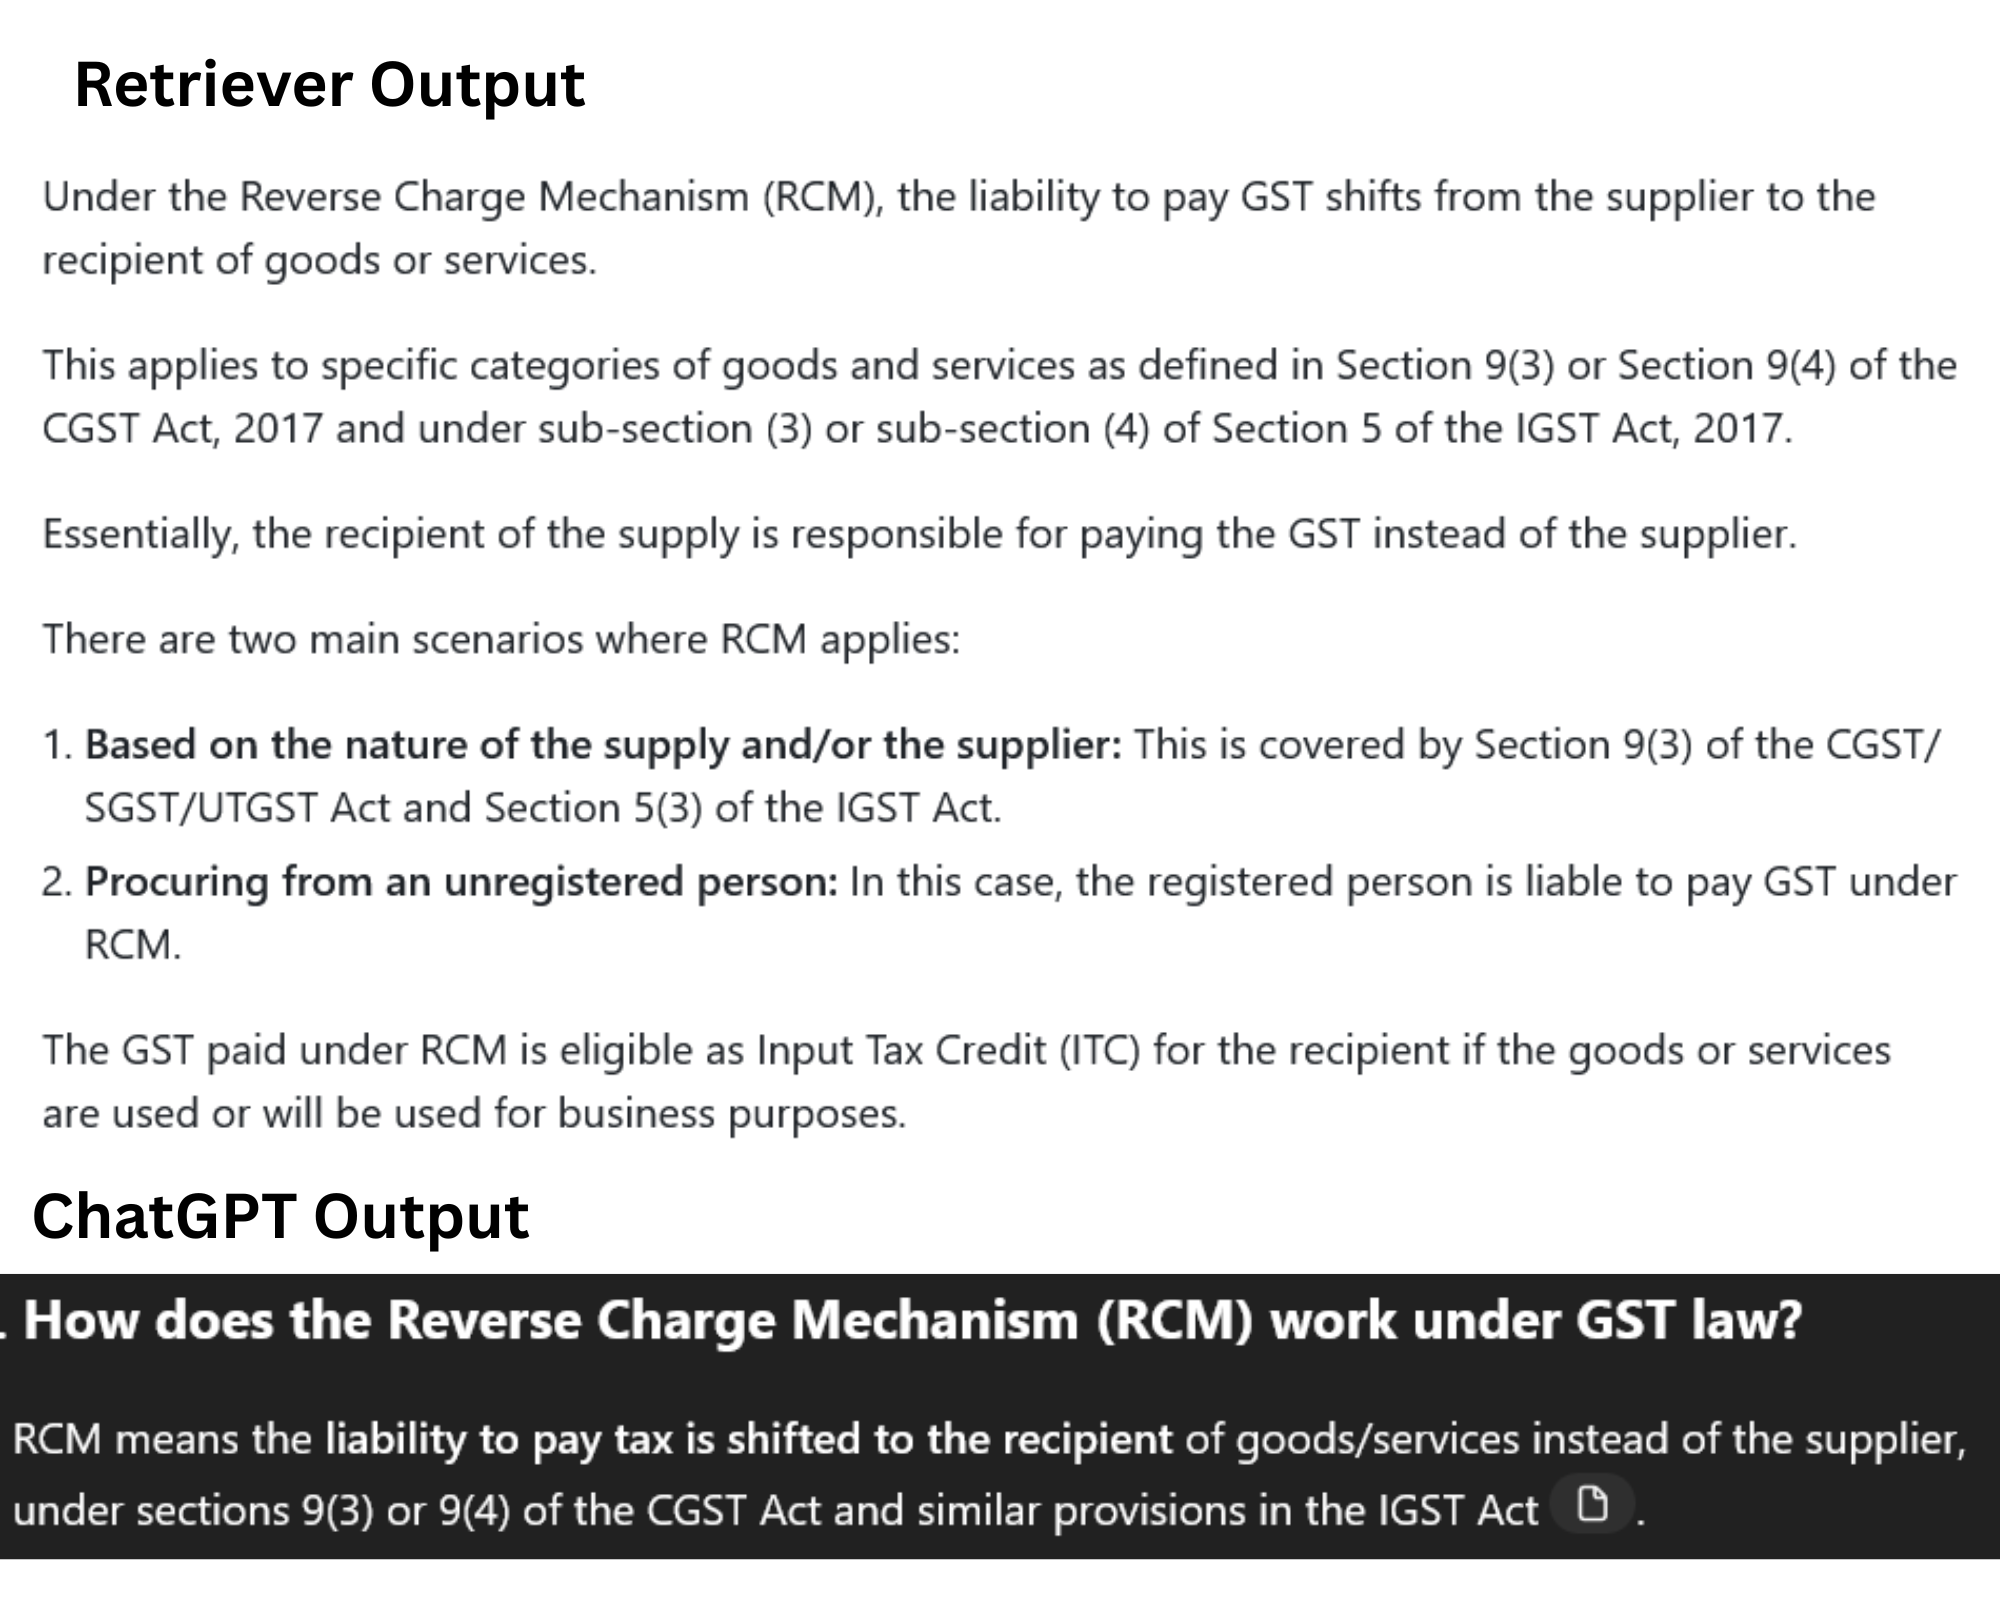

___

2. Explain the role and structure of the GST Council.

In [31]:
query_2 = '''Explain the role and structure of the GST Council.?'''
Answer_2= qa_chain.run(query_2)

print(Answer_2)

The GST Council is a body responsible for making recommendations on various aspects of the Goods and Services Tax (GST) in India. 

Here's a breakdown of its role and structure:

**Role:**

* **Subsuming Taxes:** Recommends which taxes, cesses, and surcharges levied by the Centre, States, and local bodies should be included under GST.
* **Goods and Services Coverage:** Decides which goods and services will be subject to GST and which will be exempted.
* **GST Framework:**  Recommends model GST laws, principles for levying GST, how to apportion Integrated GST (IGST), and the rules governing the place of supply.
* **Threshold Limit:**  Sets the turnover threshold below which businesses may be exempt from GST.
* **GST Rates:**  Determines GST rates, including floor rates and bands.

**Structure:**

* **Composition:** The Council consists of the Union Finance Minister (Chairman), the Minister of State (Revenue), and the State Finance/Taxation Ministers.
* **Decision-Making:**  Decisions ar

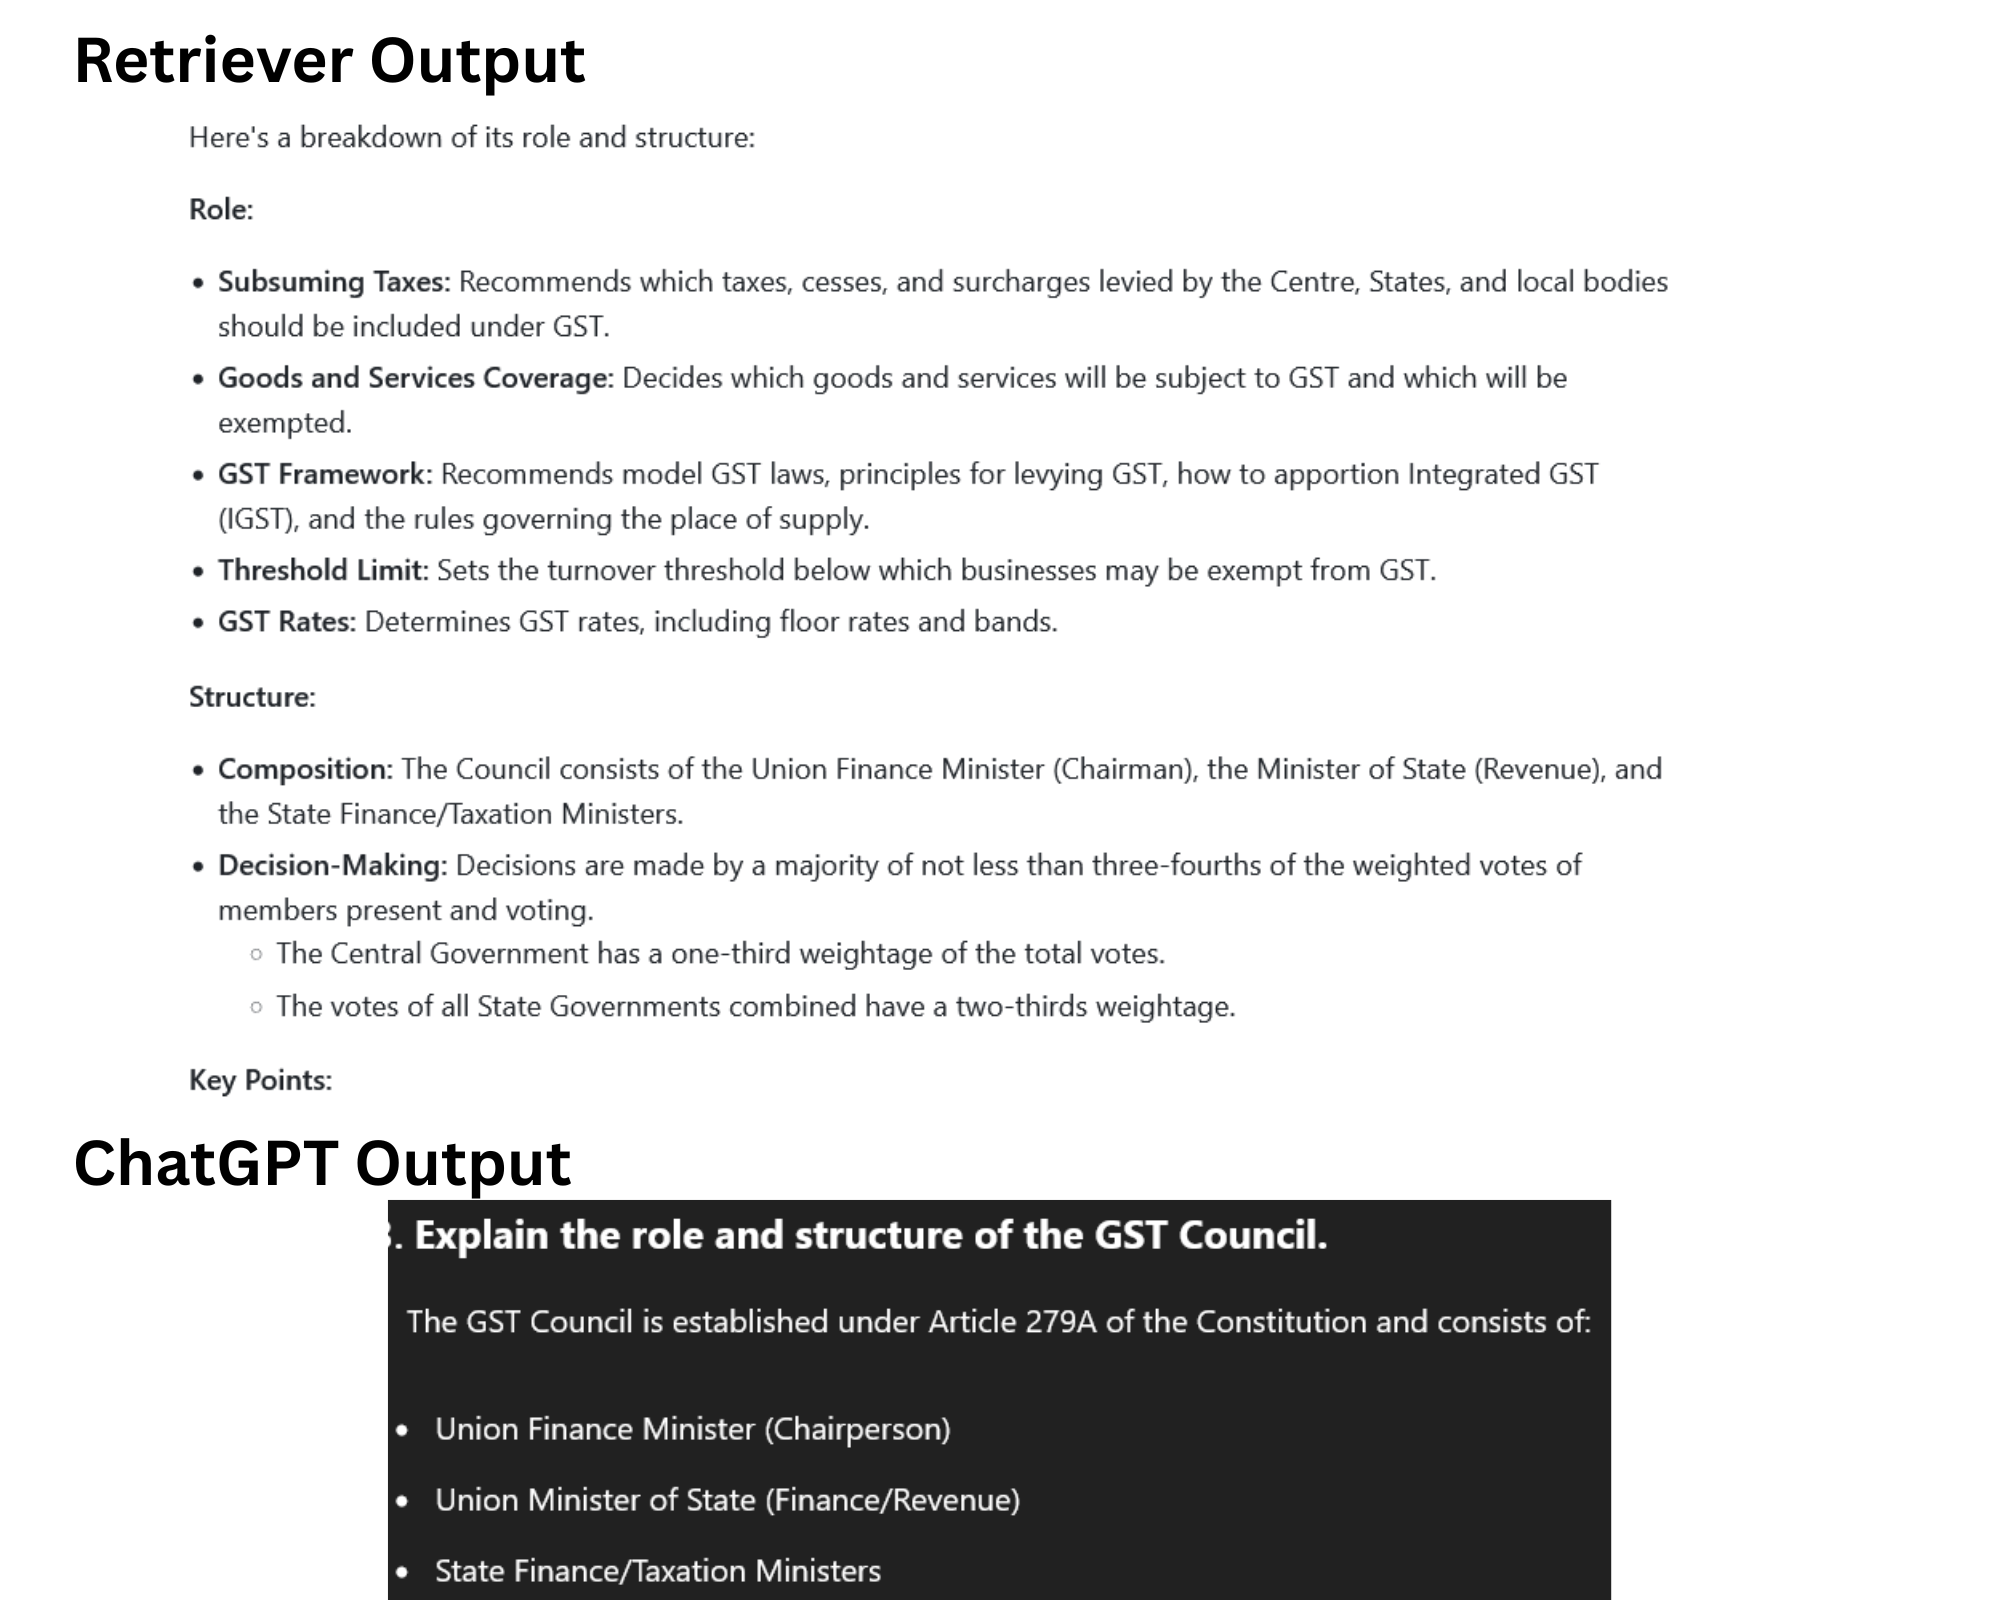

____________

3. What are the threshold limits for GST registration in different Indian states?

In [32]:
query_3 = '''What are the threshold limits for GST registration in different Indian states?'''
Answer_3= qa_chain.run(query_3)

print(Answer_3)

The threshold limits for GST registration in India are as follows:

* **For the supply of goods:**
    * ₹40 lakhs is the limit for registration, but states have the option to opt for a lower limit of ₹20 lakhs.
    * ₹10 lakhs is the limit for special category states (Assam, Arunachal Pradesh, Himachal Pradesh, Meghalaya, Sikkim, and Uttarakhand). 

* **For the supply of services:** ₹20 lakhs is the limit for registration.
    * ₹10 lakhs is the limit for special category states.

The GST Council increased the threshold limits for GST registration w.e.f. 01 April 2019, specifically for the exclusive supply of goods.  


The document states that states have an option to decide about one of the limits within a week's time, so the exact threshold limit for each state may vary. 



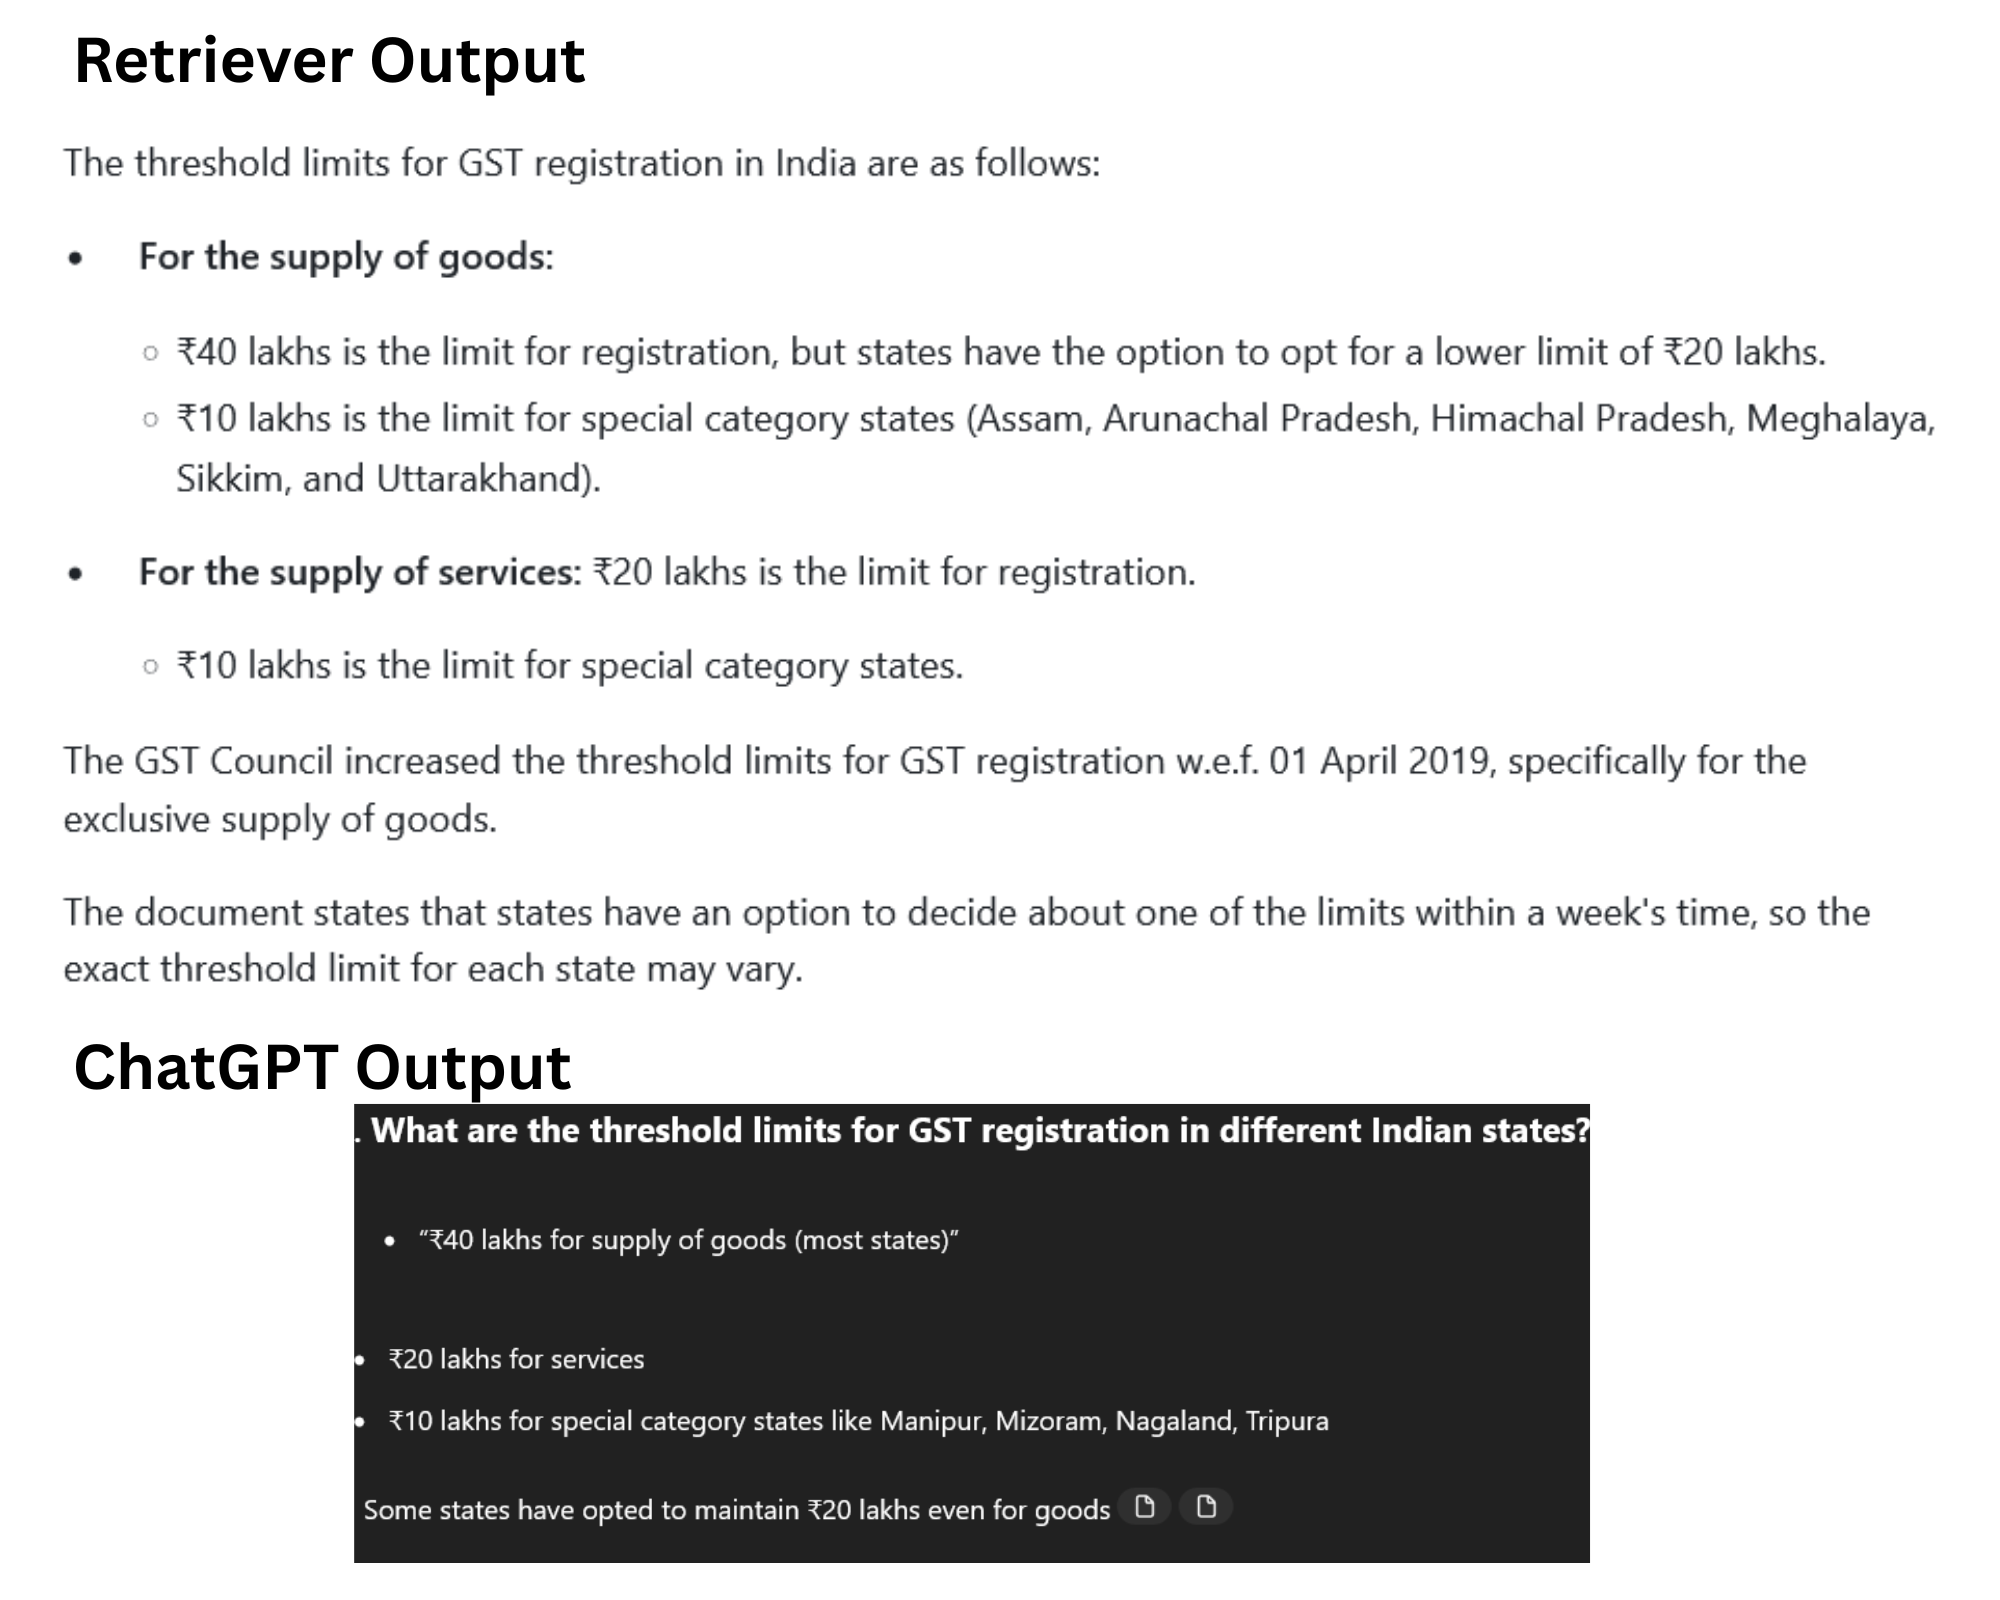

____

4. How is Input Tax Credit (ITC) treated in case of death of a sole proprietor?

In [33]:
query_4 = '''How is Input Tax Credit (ITC) treated in case of death of a sole proprietor?'''
Answer_4= qa_chain.run(query_4)

print(Answer_4)

According to the provided text, in the case of death of a sole proprietor, the transferee/successor shall file FORM GST ITC-02 in respect of the registration which is required to be cancelled on account of death of the sole proprietor. 

This form is required to be filed by the transferee/successor before filing the application for cancellation of such registration. 



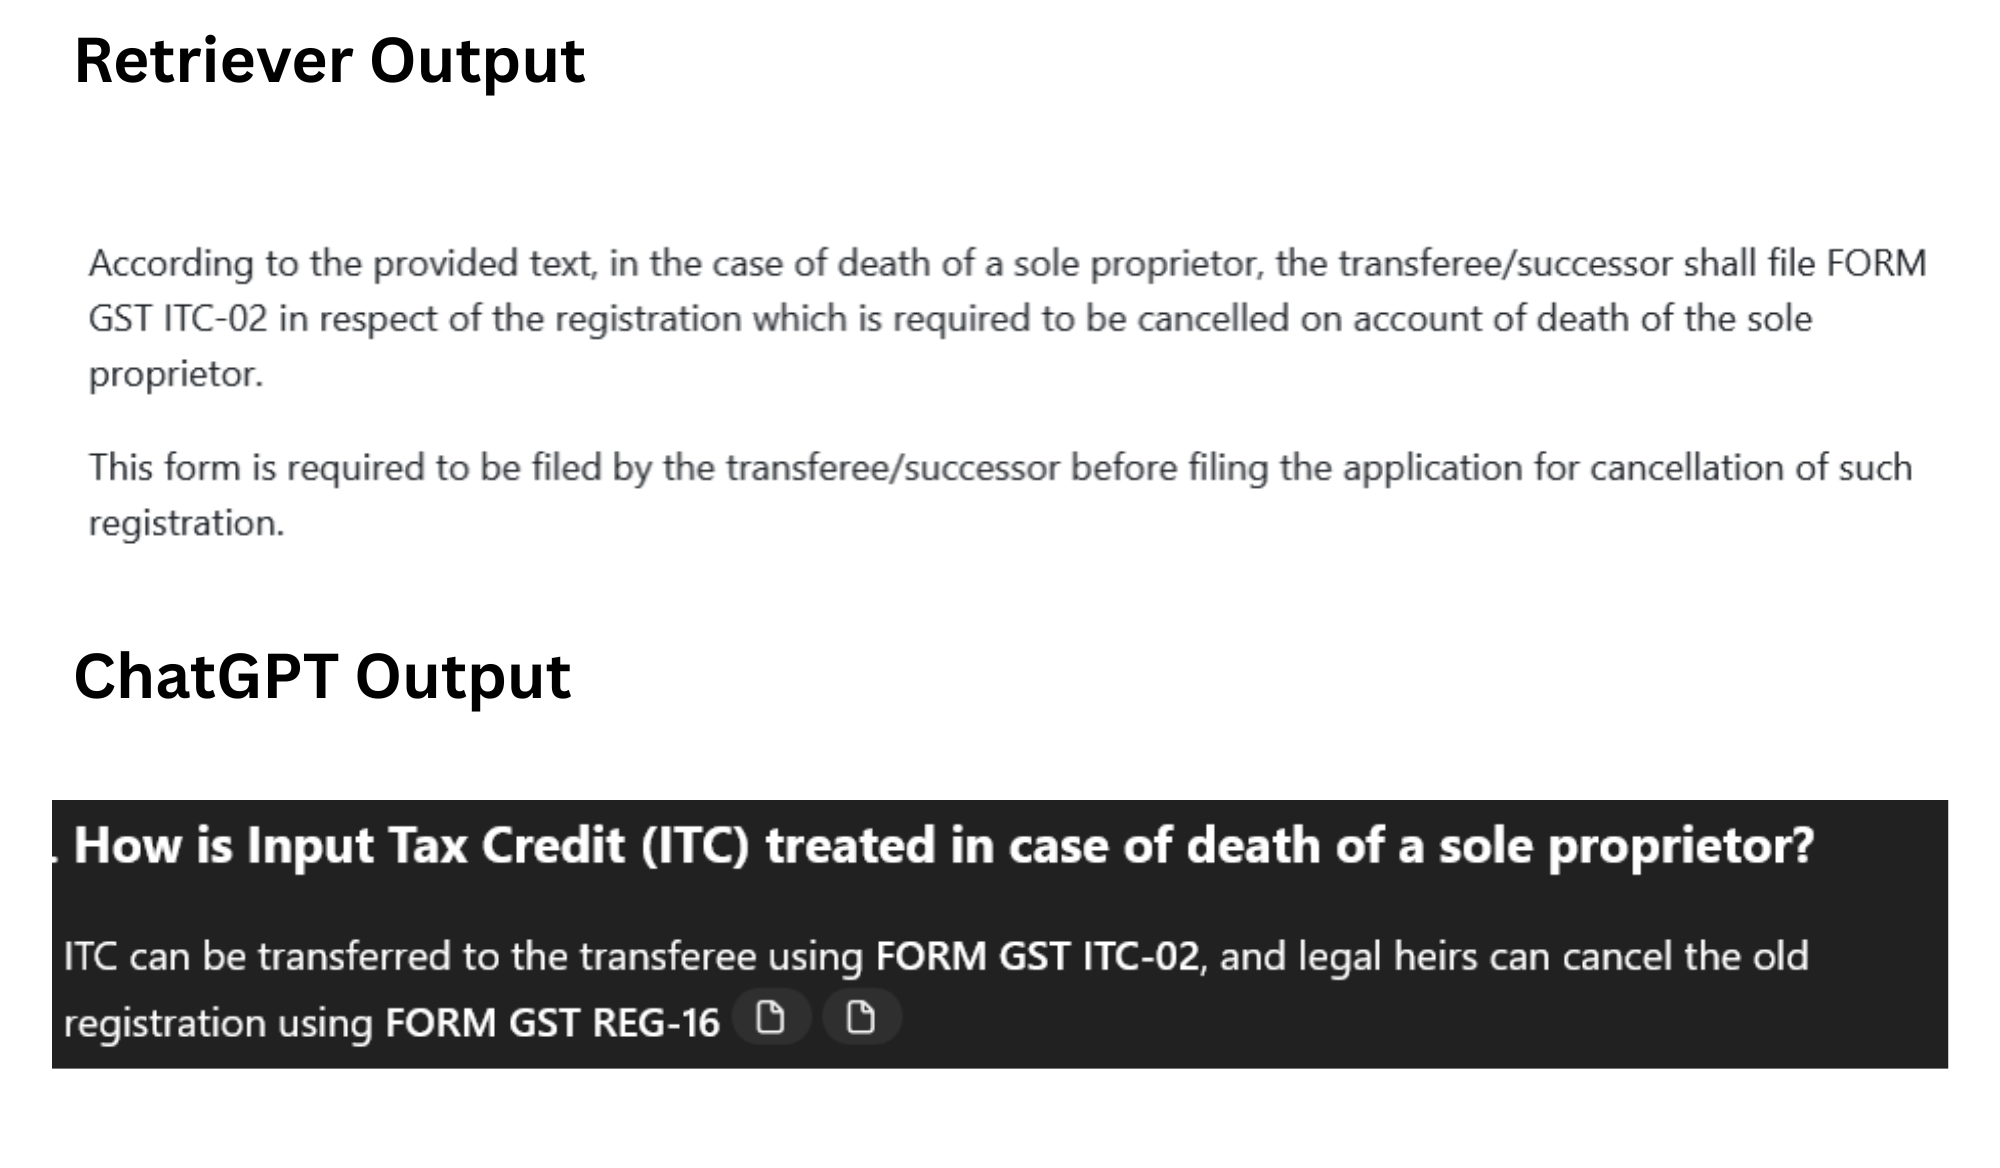

___

5. How does GST apply to export of services under Section 2(6) of the IGST Act?

In [35]:
query_5 = '''How does GST apply to export of services under Section 2(6) of the IGST Act?'''
Answer_5= qa_chain.run(query_5)

print(Answer_5)

According to the provided text, supplies of goods and services for exports are treated as “Zero rated supplies” under the IGST Act, 2017.  This means that registered taxable persons exporting goods and services are not liable to pay GST on these exports. 


The document clarifies that sub-clause (iv) of Section 2(6) of the Integrated Goods & Services Tax Act, 2017 ("the IGST Act") relates to the export of services. However, it does not provide specific details on how GST applies to the export of services under this sub-clause.  



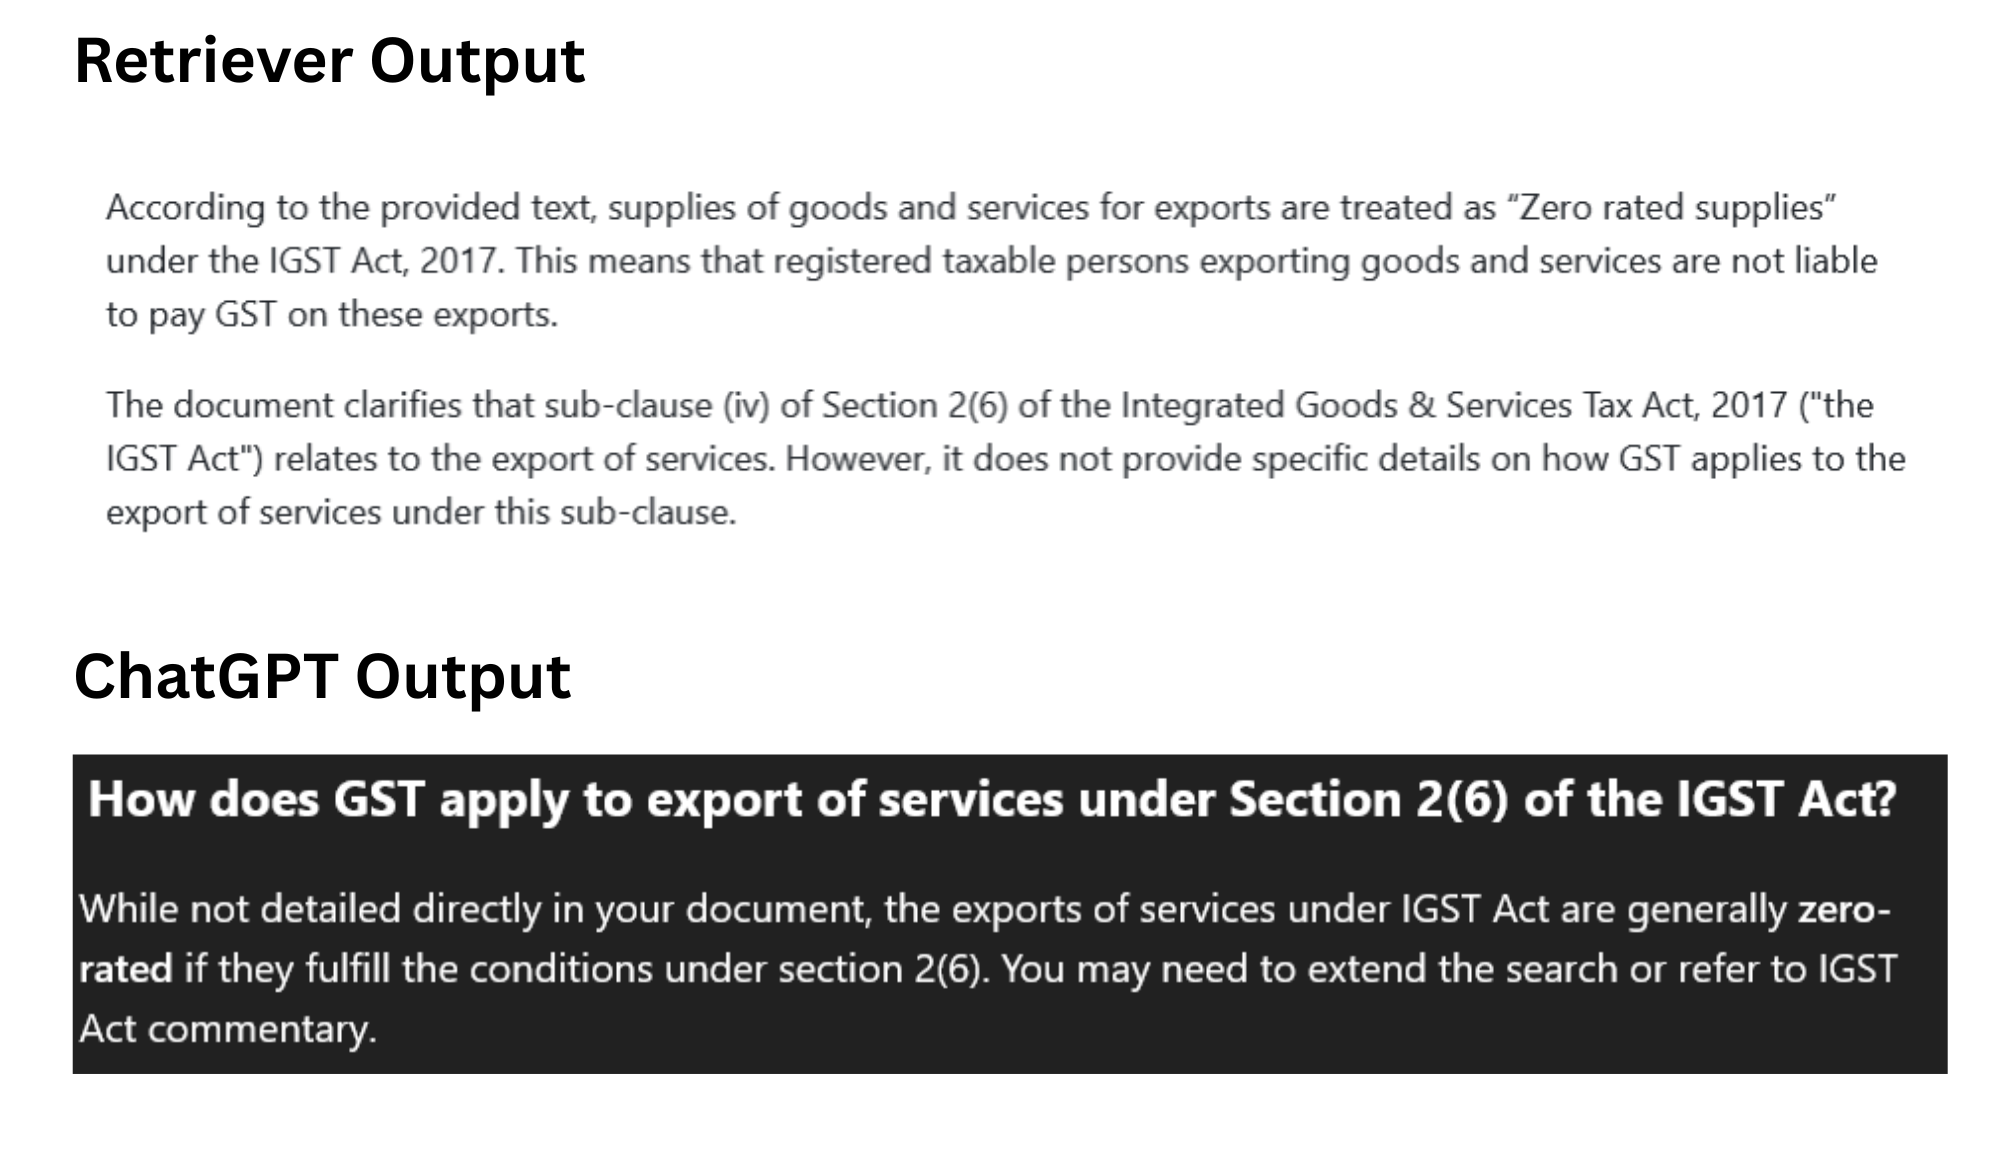

___

# **Conclusion**

Although the retriever outputs are often similar across queries, the quality and relevance of those results depend heavily on two critical factors: the quality of the embeddings and the capability of the language model. Together, they play a vital role in accurately retrieving and understanding the intended answer. This is precisely why a hybrid approach to chunking—combining both retriever and LLM—proves to be highly effective. It ensures not only efficient retrieval but also meaningful and context-aware responses, making it a robust strategy for real-world question-answering systems.